In [231]:
import re
from pulp import *
from itertools import product
import pytesseract
import cv2
import numpy as np
import pandas as pd
import imutils
from imutils import contours
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
%matplotlib inline

## OpenCV

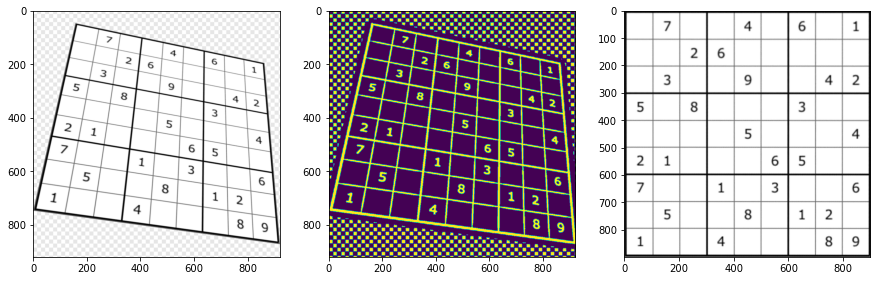

In [232]:
# Открываем изображение с судоку
img = cv2.imread('examples/7.png')

# Находим квадрат с судоку
blurry = cv2.GaussianBlur(img, (5, 5), 5)
gray = cv2.cvtColor(blurry, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,77,5)
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
grabs = imutils.grab_contours(cnts)
grabs = sorted(grabs, key=cv2.contourArea, reverse=True)
location = None
for grab in grabs:
    approx = cv2.approxPolyDP(grab, 15, True)
    if len(approx) == 4:
        rect = np.zeros((4, 2), dtype = "float32")
        cutt = approx[:,0]
        s = cutt.sum(axis = 1)
        
        # Сортировка углов по часовой стрелке
        rect[0] = cutt[np.argmin(s)]
        rect[2] = cutt[np.argmax(s)]
        diff = np.diff(cutt, axis = 1)
        rect[1] = cutt[np.argmin(diff)]
        rect[3] = cutt[np.argmax(diff)]
        location = rect
        break

height = 900
width = 900
pts1 = np.float32([location[0], location[1], location[3], location[2]])
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

# Трансформируем перспективу
matrix = cv2.getPerspectiveTransform(pts1, pts2)
board = cv2.warpPerspective(img, matrix, (width, height))
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(img)
ax[1].imshow(thresh)
ax[2].imshow(board)

,1,2,3,4,5,6,7,8,9
1,NaN,7,NaN,NaN,4,NaN,6,NaN,NaN
2,NaN,NaN,2,6,NaN,NaN,NaN,NaN,NaN
3,NaN,3,NaN,NaN,9,NaN,NaN,4,2
4,NaN,NaN,8,NaN,NaN,NaN,3,NaN,NaN
5,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4
6,2,1,NaN,NaN,NaN,6,5,NaN,NaN
7,7,NaN,NaN,1,NaN,3,NaN,NaN,6
8,NaN,5,NaN,NaN,8,NaN,1,2,NaN
9,1,NaN,NaN,4,NaN,NaN,NaN,8,9


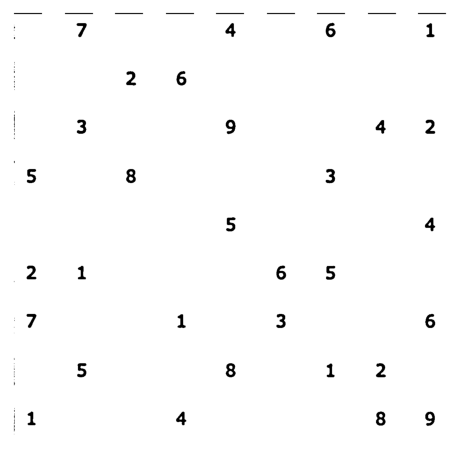

In [233]:
df_final = pd.DataFrame(index=range(1, 10), columns=range(1, 10))

fig, ax = plt.subplots(9, 9, figsize=(8,8))
split = np.split(board, 9, axis=1)
plmat = []
for col,j  in enumerate(split):
    digs = np.split(j, 9)
    for row,d in enumerate(digs):
        g = d.copy()[10:90, 10:90]
        e = d.copy()[10:90, 10:90]
        g = cv2.GaussianBlur(g, (5,5), 5)
        g = cv2.cvtColor(g, cv2.COLOR_BGR2GRAY)
        g = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5)
        cn = cv2.findContours(g, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        grs = imutils.grab_contours(cn)
        grs = sorted(grs, key=cv2.contourArea, reverse=True)
        
        msk = np.ones(e.shape, dtype=np.uint8)
        cv2.drawContours(msk, grs, -1, (255,255,255), -1)
        rst = cv2.bitwise_and((0,0,0), msk)
        rst[msk==1] = 255
        rst = cv2.copyMakeBorder(rst, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255,255,255))
        ax[row][col].imshow(rst)
        ax[row][col].axis('off')
        text = pytesseract.image_to_string(rst, config='--psm 10 digits')
        plmat.append([text, str(row+1), str(col+1)])
        df_final.iloc[row, col] = text

        
        
df_final.fillna('', inplace=True)
df_final = df_final.applymap(lambda x: x[:x.find('\n')])
df_final = df_final.applymap(lambda x: ''.join(re.findall('[1-9]', x)))
df_final = df_final[~(df_final=='')]

df_final

## Pulp

In [234]:
nums = [*map(str, [*range(1,10)])] # список чисел от 1 до 9 со строковым типом
rows = nums
cols = nums
vals = nums

choices = LpVariable.dicts("Choice", (vals, rows, cols), 0, 1, LpInteger)

In [235]:
prob = LpProblem("Судоку", LpMaximize)
prob += 0, "Целевая функция" # Задаётся нулём, так как нас интересует только подбор значения согласно ограничениям

In [236]:
for r, c in product(rows, cols):
    prob += lpSum([choices[v][r][c] for v in vals]) == 1, ""

for v, r in product(vals, rows):
    prob += lpSum([choices[v][r][c] for c in cols]) == 1, ""

for v, c in product(vals, cols):
    prob += lpSum([choices[v][r][c] for r in rows]) == 1, ""

In [237]:
grid = range(3)
subs = [[(rows[3*i+k],cols[3*j+l]) for k,l in product(grid, grid)] for i,j in product(grid, grid)]

for v,s in product(vals, subs):
    prob += lpSum([choices[v][r][c] for (r, c) in s]) == 1, ""

In [238]:
for i in plmat:
    i[0] = ''.join(re.findall('[\d]', i[0]))

sudoku_map = plmat.copy()
for i in plmat:
    if i[0] == '':
        sudoku_map.remove(i)
        
for num in sudoku_map:
    prob += choices[num[0]][num[1]][num[2]] == 1, ""

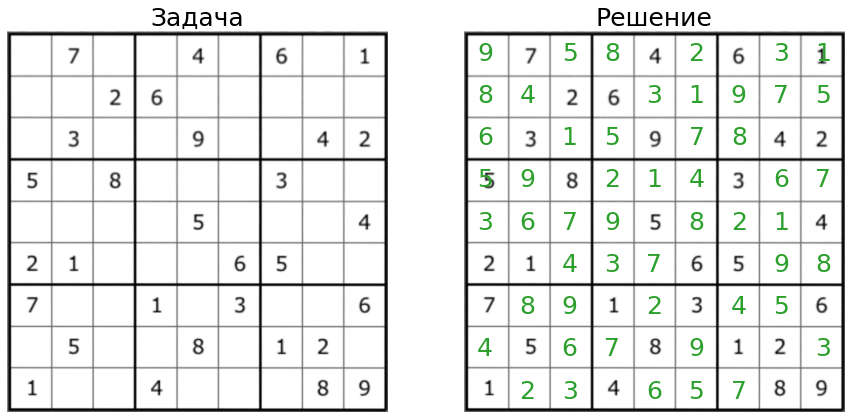

In [239]:
prob.solve()

fig, axes = plt.subplots(1,2, figsize=(15,15))
axes[0].imshow(board)
axes[0].set_title('Задача', fontsize=25)
axes[1].imshow(board)
axes[1].set_title('Решение', fontsize=25)
for a in axes:
    a.axis('off')

y = 50
for r in rows:
    x = 50
    for c,v in product(cols, vals):
        if choices[v][r][c].value() == 1:
            if [v,r,c] not in sudoku_map:
                axes[1].text(x,y,v, ha='center', va='center', fontsize=25, color='tab:green')
            x += 100
    y += 100
